# Project Configuration

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # plot & image processing
from skimage.morphology import label
from skimage.data import imread

import cv2
import random
import os
import time
import sys

# Configurations
# Split x ratio of train dataset for validation 
TRAINING_VALIDATION_RATIO = 0.2
WORKING_DIR = '/projectnb/ece601/Ship_detectT9/work'
INPUT_DIR = '/projectnb/ece601/Ship_detectT9'
OUTPUT_DIR = '/projectnb/ece601/Ship_detectT9/output'
LOGS_DIR = os.path.join(WORKING_DIR, "logs")
TRAIN_DATA_PATH = os.path.join(INPUT_DIR, 'train_v2')
TEST_DATA_PATH = os.path.join(INPUT_DIR, 'test_v2')
SAMPLE_SUBMISSION_PATH = os.path.join(INPUT_DIR, 'sample_submission_v2.csv')
TRAIN_SHIP_SEGMENTATIONS_PATH = os.path.join(INPUT_DIR, 'train_ship_segmentations_v2.csv')
MASK_RCNN_PATH = os.path.join(WORKING_DIR, 'Mask_RCNN-master')
COCO_WEIGHTS_PATH = os.path.join(WORKING_DIR, "mask_rcnn_coco.h5")
SHIP_CLASS_NAME = 'ship'
IMAGE_WIDTH = 768
IMAGE_HEIGHT = 768
SHAPE = (IMAGE_WIDTH, IMAGE_HEIGHT)

test_ds = os.listdir(TEST_DATA_PATH)
train_ds = os.listdir(TRAIN_DATA_PATH)

print('Working Dir:', WORKING_DIR, os.listdir(WORKING_DIR))
print('Input Dir:', INPUT_DIR, os.listdir(INPUT_DIR))
print('train dataset from: {}, {}'.format(TRAIN_DATA_PATH, len(train_ds)))
print('test dataset from: {}, {}'.format(TRAIN_DATA_PATH, len(test_ds)))
print(TRAIN_SHIP_SEGMENTATIONS_PATH)

Working Dir: /projectnb/ece601/Ship_detectT9/work ['Mask_RCNN-master']
Input Dir: /projectnb/ece601/Ship_detectT9 ['res34', 'validation.png', 'model_2', 'output', '.ipynb_checkpoints', 'seg_model_weights.best.hdf5', 'train_v2', 'kernel.ipynb', 'model2-Copy2.ipynb', 'main.py', 'overview.png', 'main.ipynb', 'model2.ipynb', 'model2-Copy1.ipynb', 'main 1.ipynb', 'seg_model.h5', 'test_v2', 'sample_submission_v2.csv', 'work', 'mask_rcnn.py', 'mask_rcnn.ipynb', 'train_ship_segmentations_v2.csv', 'fullres_model.h5']
train dataset from: /projectnb/ece601/Ship_detectT9/train_v2, 192557
test dataset from: /projectnb/ece601/Ship_detectT9/train_v2, 15606
/projectnb/ece601/Ship_detectT9/train_ship_segmentations_v2.csv


# Preparing Dataset
## Run-length mask encording

In [2]:
# Read mask encording from the input CSV file 
masks = pd.read_csv(TRAIN_SHIP_SEGMENTATIONS_PATH)
masks.head()

,ImageId,EncodedPixels
0,00003e153.jpg,NaN
1,0001124c7.jpg,NaN
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...
4,000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...


Each mask are stored by run length pixel encoding, where:
* ImageId is the filename of the corresponding image in train_v2.zip
* EncodedPixels contain in run-length encoding format, [StartPosition] [Length] pairs of masked pixels
* StartPosition is a position in 1D array
* [For example, '1 3 10 5' implies pixels 1,2,3,10,11,12,13,14 are to be included in the mask.](https://www.kaggle.com/c/airbus-ship-detection#evaluation) 

## Utility functions
Utility functions are adapted from [Run Length Encode And Decode](https://www.kaggle.com/paulorzp/run-length-encode-and-decode) and [Baseline U Net Model Part 1](https://www.kaggle.com/kmader/baseline-u-net-model-part-1) 

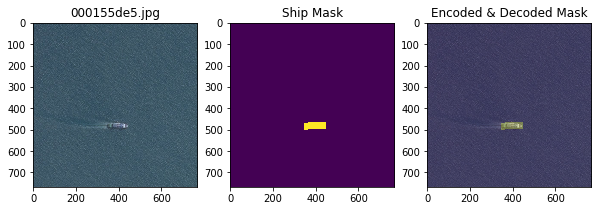

000155de5.jpg  Check Decoding->Encoding RLE_0: 1 -> RLE_1: 1


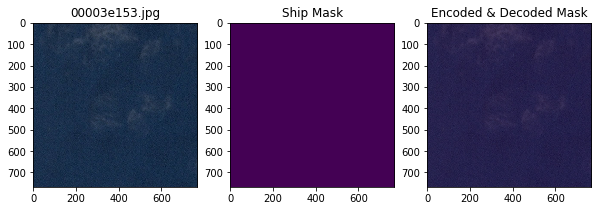

00003e153.jpg  Check Decoding->Encoding RLE_0: 1 -> RLE_1: 0
It could be different when there is no mask.


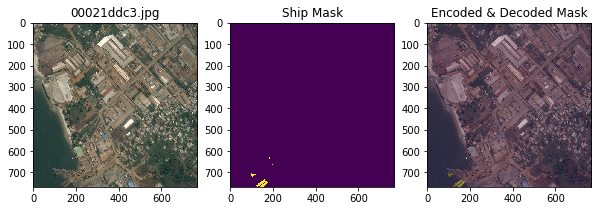

00021ddc3.jpg  Check Decoding->Encoding RLE_0: 9 -> RLE_1: 4
It could be different when there are masks overlapped.


In [3]:
# ref: https://www.kaggle.com/kmader/baseline-u-net-model-part-1
def multi_rle_encode(img):
    labels = label(img[:, :, 0])
    return [rle_encode(labels==k) for k in np.unique(labels[labels>0])]

# ref: https://www.kaggle.com/paulorzp/run-length-encode-and-decode
def rle_encode(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated: [start0] [length0] [start1] [length1]... in 1d array
    '''
    # reshape to 1d array
    pixels = img.T.flatten() # Needed to align to RLE direction
    # pads the head & the tail with 0 & converts to ndarray
    pixels = np.concatenate([[0], pixels, [0]])
    # gets all start(0->1) & end(1->0) positions 
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    # transforms end positions to lengths
    runs[1::2] -= runs[::2]
    # converts to the string formated: '[s0] [l0] [s1] [l1]...'
    return ' '.join(str(x) for x in runs)

def rle_decode(mask_rle, shape=SHAPE):
    '''
    mask_rle: run-length as string formated: [start0] [length0] [start1] [length1]... in 1d array
    shape: (height,width) of array to return 
    Returns numpy array according to the shape, 1 - mask, 0 - background
    '''
    s = mask_rle.split()
    # gets starts & lengths 1d arrays 
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0::2], s[1::2])]
    starts -= 1
    # gets ends 1d array
    ends = starts + lengths
    # creates blank mask image 1d array
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    # sets mark pixles
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    # reshape as a 2d mask image
    return img.reshape(shape).T  # Needed to align to RLE direction

def masks_as_image(in_mask_list, shape=SHAPE):
    '''Take the individual ship masks and create a single mask array for all ships
    in_mask_list: pd Series: [idx0] [RLE string0]...
    Returns numpy array as (shape.h, sahpe.w, 1)
    '''
    all_masks = np.zeros(shape, dtype = np.int16)
    # if isinstance(in_mask_list, list):
    for mask in in_mask_list:
        if isinstance(mask, str):
            all_masks += rle_decode(mask)
    return np.expand_dims(all_masks, -1)

def shows_decode_encode(image_id, path=TRAIN_DATA_PATH):
    '''Show image, ship mask, and encoded/decoded result
    '''
    fig, axarr = plt.subplots(1, 3, figsize = (10, 5))
    # image
    img_0 = imread(os.path.join(path, image_id))
    axarr[0].imshow(img_0)
    axarr[0].set_title(image_id)
    
    # input mask
    rle_1 = masks.query('ImageId=="{}"'.format(image_id))['EncodedPixels']
    img_1 = masks_as_image(rle_1)
    # takes 2d array (shape.h, sahpe.w)
    axarr[1].imshow(img_1[:, :, 0])
    axarr[1].set_title('Ship Mask')
    
    # encode & decode mask 
    rle_2 = multi_rle_encode(img_1)
    img_2 = masks_as_image(rle_2)
    axarr[2].imshow(img_0)
    axarr[2].imshow(img_2[:, :, 0], alpha=0.3)
    axarr[2].set_title('Encoded & Decoded Mask')
    plt.show()
    print(image_id , ' Check Decoding->Encoding',
          'RLE_0:', len(rle_1), '->',
          'RLE_1:', len(rle_2))

# inspects a few example
shows_decode_encode('000155de5.jpg')
shows_decode_encode('00003e153.jpg')
print('It could be different when there is no mask.')
shows_decode_encode('00021ddc3.jpg')
print('It could be different when there are masks overlapped.')

## Split Test and Validation datasets


unique_img_ids groupby took: 12.334630489349365


,ImageId,ships,RleMaskList
52331,45ada9872.jpg,0,[nan]
124703,a5dea49f1.jpg,0,[nan]
125061,a655872dc.jpg,0,[nan]


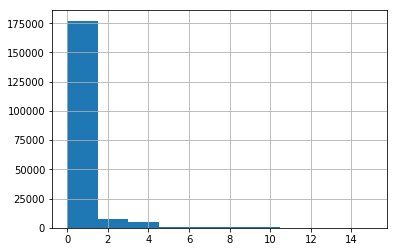

In [4]:
# check if a mask has a ship 
masks['ships'] = masks['EncodedPixels'].map(lambda encoded_pixels: 1 if isinstance(encoded_pixels, str) else 0)
# sum ship# by ImageId and create the unique image id/mask list
start_time = time.time()
unique_img_ids = masks.groupby('ImageId').agg({'ships': 'sum'})
unique_img_ids['RleMaskList'] = masks.groupby('ImageId')['EncodedPixels'].apply(list)
unique_img_ids = unique_img_ids.reset_index()
end_time = time.time() - start_time
print("unique_img_ids groupby took: {}".format(end_time))

# Only care image with ships
#unique_img_ids = unique_img_ids[unique_img_ids['ships'] > 0]
unique_img_ids['ships'].hist()
unique_img_ids.sample(3)

154044 training masks
38512 validation masks


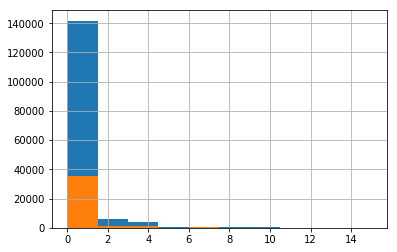

In [5]:
# split to training & validation sets 
from sklearn.model_selection import train_test_split
train_ids, val_ids = train_test_split(unique_img_ids, 
                 test_size = TRAINING_VALIDATION_RATIO, 
                 stratify = unique_img_ids['ships'])
print(train_ids.shape[0], 'training masks')
print(val_ids.shape[0], 'validation masks')
train_ids['ships'].hist()
val_ids['ships'].hist()


# Mask R-CNN model
This project uses [Mask R-CNN for object detection and instance segmentation on Keras and TensorFlow](https://github.com/matterport/Mask_RCNN) for the task, with minor changes.
* Forked the github project for customization: [forked Mask_RCNN](https://github.com/samlin001/Mask_RCNN)  
* Add [SAVE_BEST_ONLY](https://keras.io/callbacks/) configuration to allow more than 17-epochs training. Because each Kaggle kernel has 5.2GB disk space limitation, and each epoch weights file is about 250MB. 

## Import Mask R-CNN mode
Download and import Mask R-CNN mode.

In [6]:
# if to clone Mask_R-CNN git when it exists 
UPDATE_MASK_RCNN = False

os.chdir(WORKING_DIR)
if UPDATE_MASK_RCNN:
    !rm -rf {MASK_RCNN_PATH}

# Downlaod Mask RCNN code to a local folder 
if not os.path.exists(MASK_RCNN_PATH):
    ! wget https://github.com/samlin001/Mask_RCNN/archive/master.zip -O Mask_RCNN-master.zip
    ! unzip Mask_RCNN-master.zip 'Mask_RCNN-master/mrcnn/*'
    ! rm Mask_RCNN-master.zip

# Import Mask RCNN
sys.path.append(MASK_RCNN_PATH)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log    

Using TensorFlow backend.


## Transform dataset
AirbusShipDetectionChallengeDataset class enables Mask R-CNN model to load Airbus Ship train v2 dataset and masks.   
This [balloon color splash sample tutorial](https://engineering.matterport.com/splash-of-color-instance-segmentation-with-mask-r-cnn-and-tensorflow-7c761e238b46) provides excellent guidances and illustration of Mask R-CNN. 

In [7]:
class AirbusShipDetectionChallengeDataset(utils.Dataset):
    """Airbus Ship Detection Challenge Dataset
    """
    def __init__(self, image_file_dir, ids, masks, image_width=IMAGE_WIDTH, image_height=IMAGE_HEIGHT):
        super().__init__(self)
        self.image_file_dir = image_file_dir
        self.ids = ids
        self.masks = masks
        self.image_width = image_width
        self.image_height = image_height
        
        # Add classes
        self.add_class(SHIP_CLASS_NAME, 1, SHIP_CLASS_NAME)
        self.load_dataset()
        
    def load_dataset(self):
        """Load dataset from the path
        """
        # Add images
        for index, row in self.ids.iterrows():
            image_id = row['ImageId']
            image_path = os.path.join(self.image_file_dir, image_id)
            rle_mask_list = row['RleMaskList']
            #print(rle_mask_list)
            self.add_image(
                SHIP_CLASS_NAME,
                image_id=image_id,
                path=image_path,
                width=self.image_width, height=self.image_height,
                rle_mask_list=rle_mask_list)

    def load_mask(self, image_id):
        """Generate instance masks for shapes of the given image ID.
        """
        info = self.image_info[image_id]
        rle_mask_list = info['rle_mask_list']
        mask_count = len(rle_mask_list)
        mask = np.zeros([info['height'], info['width'], mask_count],
                        dtype=np.uint8)
        i = 0
        for rel in rle_mask_list:
            if isinstance(rel, str):
                np.copyto(mask[:,:,i], rle_decode(rel))
            i += 1
        
        # Return mask, and array of class IDs of each instance. Since we have
        # one class ID only, we return an array of 1s
        return mask.astype(np.bool), np.ones([mask.shape[-1]], dtype=np.int32)
    
    def image_reference(self, image_id):
        """Return the path of the image."""
        info = self.image_info[image_id]
        if info['source'] == SHIP_CLASS_NAME:
            return info['path']
        else:
            super(self.__class__, self).image_reference(image_id)

## Model configurations
Override [the default configurations](https://github.com/samlin001/Mask_RCNN/blob/master/mrcnn/config.py) for the challenge.

In [8]:
class AirbusShipDetectionChallengeGPUConfig(Config):
    """
    Configuration of Airbus Ship Detection Challenge Dataset 
    Overrides values in the base Config class.
    From https://github.com/samlin001/Mask_RCNN/blob/master/mrcnn/config.py
    """
    # https://www.kaggle.com/docs/kernels#technical-specifications
    NAME = 'ASDC_GPU'
    # NUMBER OF GPUs to use.
    GPU_COUNT = 1
    IMAGES_PER_GPU = 4
    
    NUM_CLASSES = 2  # ship or background
    IMAGE_MIN_DIM = IMAGE_WIDTH
    IMAGE_MAX_DIM = IMAGE_WIDTH
    STEPS_PER_EPOCH = 300
    VALIDATION_STEPS = 100
    SAVE_BEST_ONLY = True
    
    # Minimum probability value to accept a detected instance
    # ROIs below this threshold are skipped
    DETECTION_MIN_CONFIDENCE = 0.95

    # Non-maximum suppression threshold for detection
    # Keep it small to merge overlapping ROIs 
    DETECTION_NMS_THRESHOLD = 0.05

    
config = AirbusShipDetectionChallengeGPUConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     4
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.95
DETECTION_NMS_THRESHOLD        0.05
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 4
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  768
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  768
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [768 768   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE           

## Prepare and load training dataset


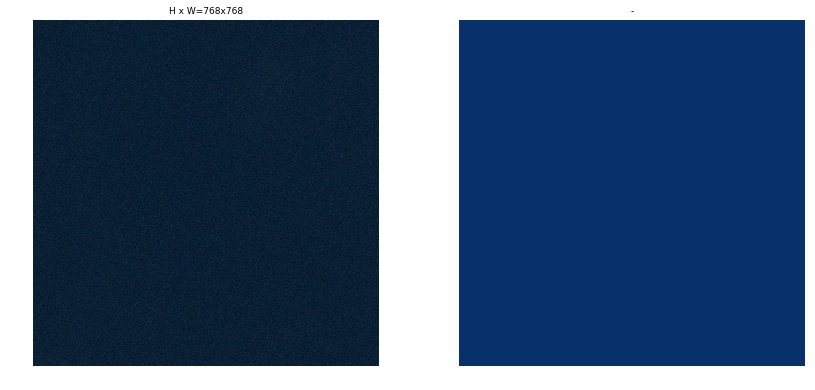

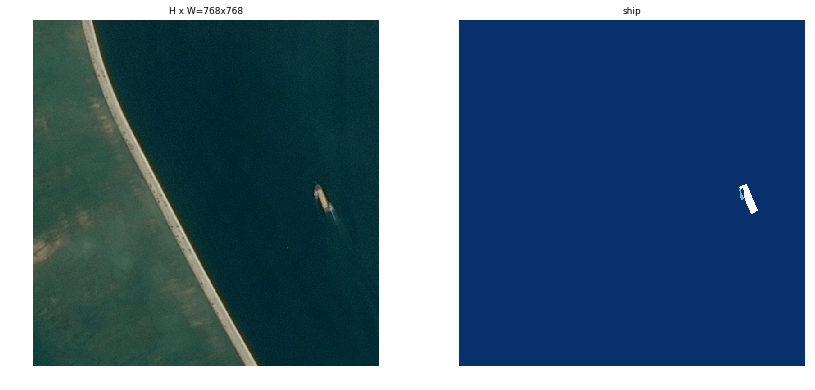

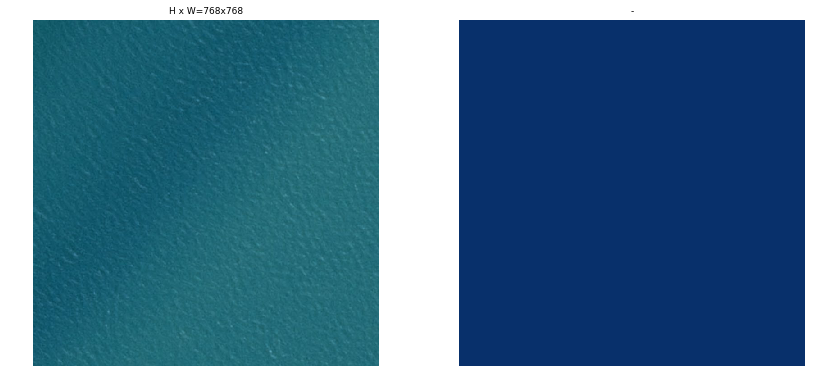

dataset prepare: 13.952197074890137


In [9]:
start_time = time.time()
# Training dataset.
dataset_train = AirbusShipDetectionChallengeDataset(image_file_dir=TRAIN_DATA_PATH, ids=train_ids, masks=masks)
dataset_train.prepare()

# Validation dataset
dataset_val = AirbusShipDetectionChallengeDataset(image_file_dir=TRAIN_DATA_PATH, ids=val_ids, masks=masks)
dataset_val.prepare()

# Load and display random samples
image_ids = np.random.choice(dataset_train.image_ids, 3)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names, limit=1)

end_time = time.time() - start_time
print("dataset prepare: {}".format(end_time))

## Load pre-trained wieghts
Pre-trained weights for MS COCO is loaded to provide a better straing point for training. 

In [10]:
start_time = time.time()
model = modellib.MaskRCNN(mode="training", config=config, model_dir=WORKING_DIR)

import errno
try:
    weights_path = model.find_last()
    load_weights = True
except FileNotFoundError:
    # if there is no previous trained weights, load COCO
    load_weights = True
    weights_path = COCO_WEIGHTS_PATH
    utils.download_trained_weights(weights_path)
    
if load_weights:
    print("Loading weights: ", weights_path)
    model.load_weights(weights_path, by_name=True, exclude=[
                "mrcnn_class_logits", "mrcnn_bbox_fc",
                "mrcnn_bbox", "mrcnn_mask"])

end_time = time.time() - start_time
print("loading weights: {}".format(end_time))

... done downloading pretrained model!
Loading weights:  /projectnb/ece601/Ship_detectT9/work/mask_rcnn_coco.h5
loading weights: 44.22183346748352


# Train the model

In [ ]:
"""Train the model."""
start_time = time.time()    
model.train(dataset_train, dataset_val,
            learning_rate=config.LEARNING_RATE / 100,
            epochs=30,
            layers='all')
end_time = time.time() - start_time
print("Train model: {}".format(end_time))
history = model.keras_model.history.history


Starting at epoch 0. LR=1e-05

Checkpoint Path: /projectnb/ece601/Ship_detectT9/work/asdc_gpu20181208T2010/mask_rcnn_asdc_gpu_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b         (Conv

/share/pkg/tensorflow/r1.10/install/py3-gpu/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr3/graduate/hxjia/.local/lib/python3.6/site-packages/keras/engine/training_generator.py:47: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 1/30
300/300 [==============================] - 442s 1s/step - loss: 2.8774 - rpn_class_loss: 0.0256 - rpn_bbox_loss: 0.4407 - mrcnn_class_loss: 0.2386 - mrcnn_bbox_loss: 0.8122 - mrcnn_mask_loss: 1.3604 - val_loss: 2.3414 - val_rpn_class_loss: 0.0346 - val_rpn_bbox_loss: 0.5234 - val_mrcnn_class_loss: 0.1660 - val_mrcnn_bbox_loss: 0.7241 - val_mrcnn_mask_loss: 0.8933
Epoch 2/30
300/300 [==============================] - 390s 1s/step - loss: 1.9765 - rpn_class_loss: 0.0348 - rpn_bbox_loss: 0.3452 - mrcnn_class_loss: 0.1762 - mrcnn_bbox_loss: 0.5782 - mrcnn_mask_loss: 0.8420 - val_loss: 1.9039 - val_rpn_class_loss: 0.0156 - val_rpn_bbox_loss: 0.4613 - val_mrcnn_class_loss: 0.0913 - val_mrcnn_bbox_loss: 0.5905 - val_mrcnn_mask_loss: 0.7452
Epoch 3/30
300/300 [==============================] - 391s 1s/step - loss: 1.7782 - rpn_class_loss: 0.0284 - rpn_bbox_loss: 0.4611 - mrcnn_class_loss: 0.0915 - mrcnn_bbox_loss: 0.4660 - mrcnn_mask_loss: 0.7312 - val_loss: 1.9963 - val_rpn_class_l

Epoch 23/30
300/300 [==============================] - 389s 1s/step - loss: 0.9027 - rpn_class_loss: 0.0154 - rpn_bbox_loss: 0.2966 - mrcnn_class_loss: 0.0495 - mrcnn_bbox_loss: 0.2553 - mrcnn_mask_loss: 0.2860 - val_loss: 0.9337 - val_rpn_class_loss: 0.0073 - val_rpn_bbox_loss: 0.3346 - val_mrcnn_class_loss: 0.0246 - val_mrcnn_bbox_loss: 0.2724 - val_mrcnn_mask_loss: 0.2947
Epoch 24/30
300/300 [==============================] - 389s 1s/step - loss: 0.8488 - rpn_class_loss: 0.0088 - rpn_bbox_loss: 0.2495 - mrcnn_class_loss: 0.0380 - mrcnn_bbox_loss: 0.2457 - mrcnn_mask_loss: 0.3069 - val_loss: 1.0384 - val_rpn_class_loss: 0.0088 - val_rpn_bbox_loss: 0.2279 - val_mrcnn_class_loss: 0.0648 - val_mrcnn_bbox_loss: 0.3676 - val_mrcnn_mask_loss: 0.3693
Epoch 25/30
300/300 [==============================] - 388s 1s/step - loss: 1.0893 - rpn_class_loss: 0.0211 - rpn_bbox_loss: 0.4776 - mrcnn_class_loss: 0.0582 - mrcnn_bbox_loss: 0.2476 - mrcnn_mask_loss: 0.2848 - val_loss: 0.9291 - val_rpn_clas

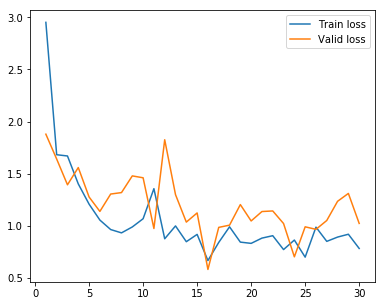

In [12]:
epochs = range(1, len(history['loss'])+1)
plt.figure(figsize=(21,11))

plt.subplot(231)
plt.plot(epochs, history["loss"], label="Train loss")
plt.plot(epochs, history["val_loss"], label="Valid loss")
plt.legend()

In [ ]:
print('Working Dir:', WORKING_DIR, os.listdir(WORKING_DIR))

# Inference


In [13]:
class InferenceConfig(AirbusShipDetectionChallengeGPUConfig):
    GPU_COUNT = 1
    # 1 image for inference 
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# create a model in inference mode
infer_model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=WORKING_DIR)

model_path = infer_model.find_last()


# Load trained weights
print("Loading weights from ", model_path)
infer_model.load_weights(model_path, by_name=True)


# # Test on a random image
# image_id = np.random.choice(dataset_val.image_ids)
# original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
#     modellib.load_image_gt(dataset_val, inference_config, 
#                            image_id, use_mini_mask=False)

# log("original_image", original_image)
# log("image_meta", image_meta)
# log("gt_class_id", gt_class_id)
# log("gt_bbox", gt_bbox)
# log("gt_mask", gt_mask)

# visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
#                             dataset_train.class_names, figsize=(8, 8))

# results = infer_model.detect([original_image], verbose=1)

# r = results[0]
# visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
#                             dataset_val.class_names, r['scores'])

# # Compute VOC-Style mean Average Precision @ IoU=0.5
# # Running on a few images. Increase for better accuracy.
# image_ids = np.random.choice(dataset_val.image_ids, 20)
# APs = []
# inference_start = time.time()
# for image_id in image_ids:
#     # Load image and ground truth data
#     image, image_meta, gt_class_id, gt_bbox, gt_mask =\
#         modellib.load_image_gt(dataset_val, inference_config,
#                                image_id, use_mini_mask=False)
#     molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
#     # Run object detection
#     results = infer_model.detect([image], verbose=1)
#     r = results[0]
#     visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
#                             dataset_val.class_names, r['scores'])

#     # Compute AP
#     AP, precisions, recalls, overlaps =\
#         utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
#                          r["rois"], r["class_ids"], r["scores"], r['masks'])
#     APs.append(AP)

# inference_end = time.time()
# print('Inference Time: %0.2f Minutes'%((inference_end - inference_start)/60))
# print("mAP: ", np.mean(APs))


Loading weights from  /projectnb/ece601/Ship_detectT9/work/asdc_gpu20181206T1716/mask_rcnn_asdc_gpu_0016.h5
Re-starting from epoch 16


x 7 y 555 h 167 w 64
x 13 y 322 h 88 w 72
x 185 y 141 h 27 w 25


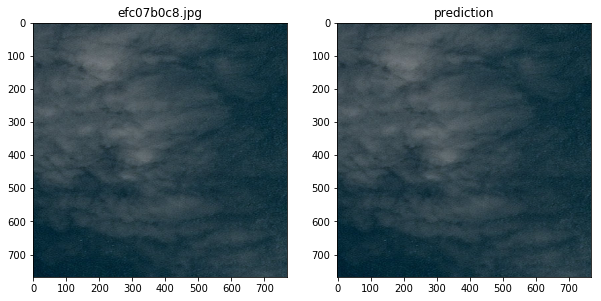

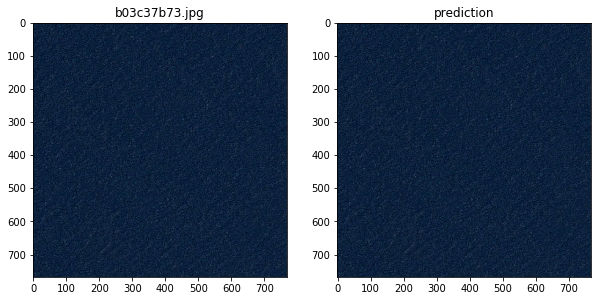

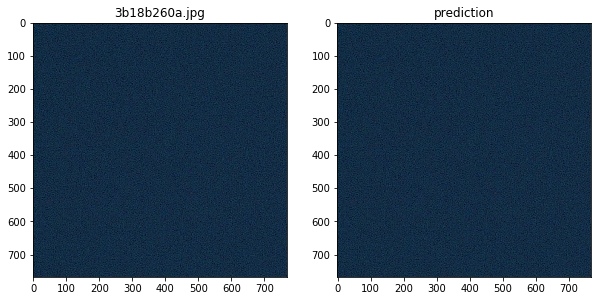

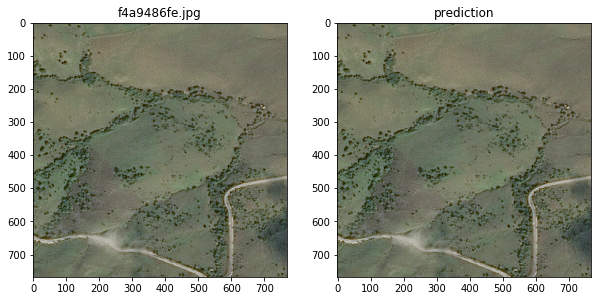

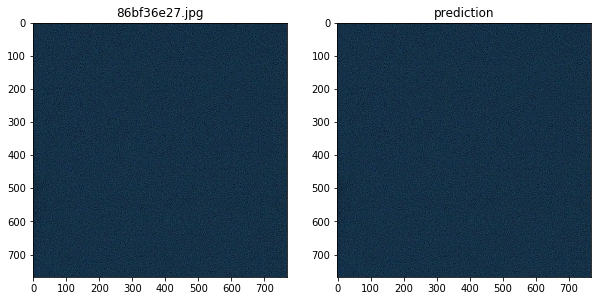

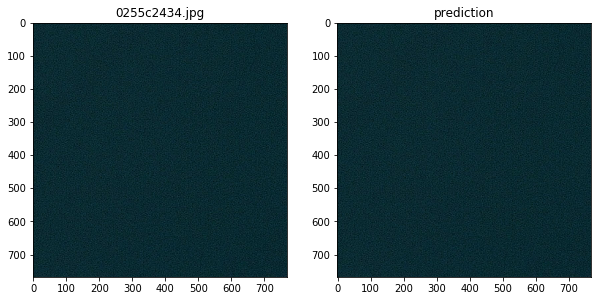

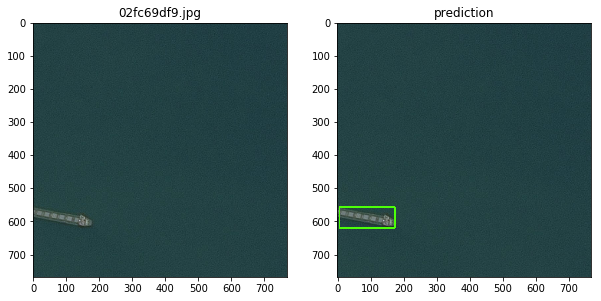

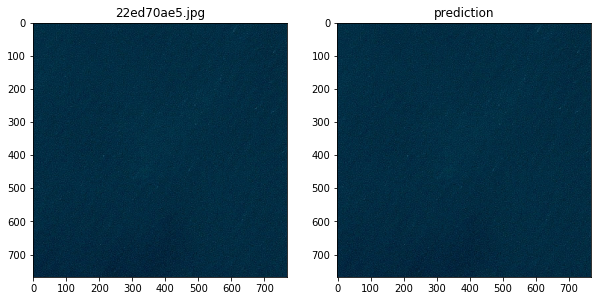

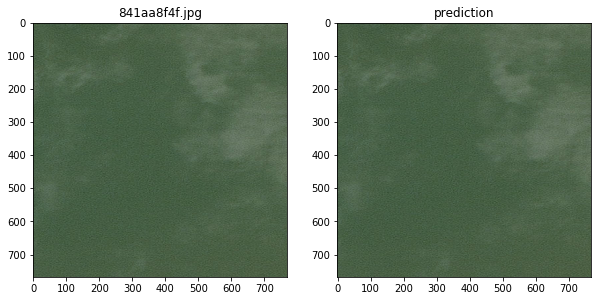

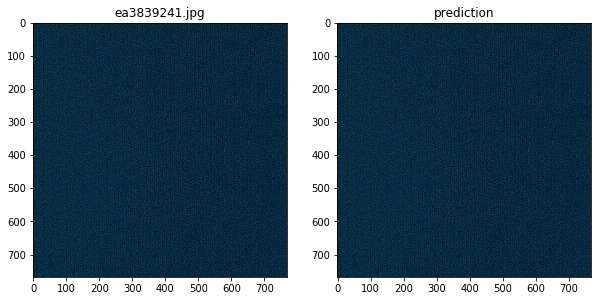

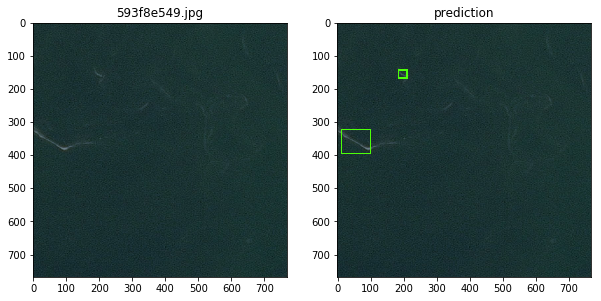

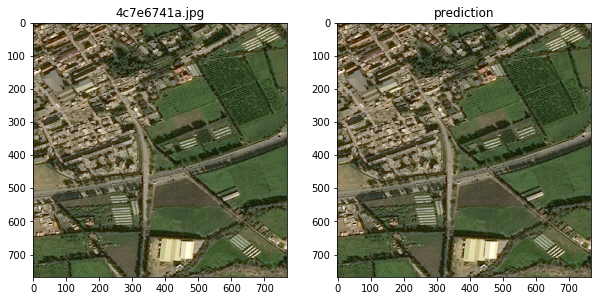

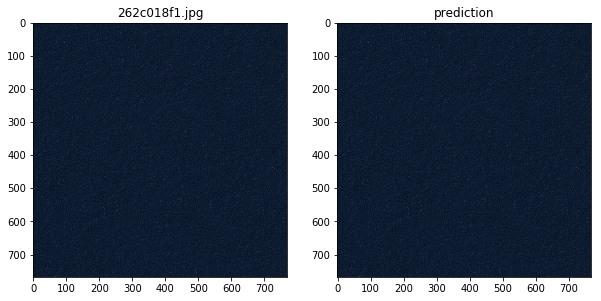

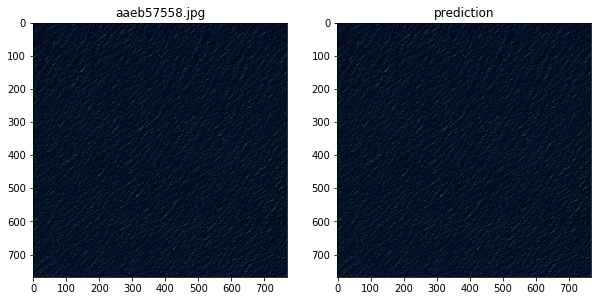

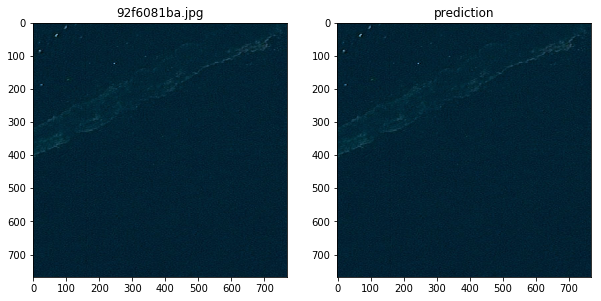

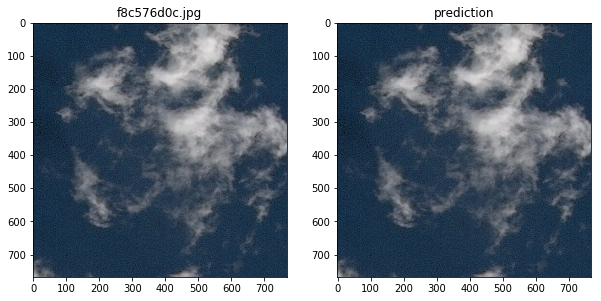

In [15]:
test_names = [f for f in os.listdir(TEST_DATA_PATH)]

# show a few test image detection example
def visualize_test(): 
    image_id = random.choice(test_names)
    
    # original image
#     print(image_id)
    raw_image = imread(os.path.join(TEST_DATA_PATH, image_id))
    image = imread(os.path.join(TEST_DATA_PATH, image_id))
    
    # assume square image 
    resize_factor = 1 ## ORIG_SIZE / config.IMAGE_SHAPE[0]
    
    # If grayscale. Convert to RGB for consistency.
    if len(image.shape) != 3 or image.shape[2] != 3:
        image = np.stack((image,) * 3, -1) 
#     image, window, scale, padding, crop = utils.resize_image(
#         image,
#         min_dim=config.IMAGE_MIN_DIM,
#         min_scale=config.IMAGE_MIN_SCALE,
#         max_dim=config.IMAGE_MAX_DIM,
#         mode=config.IMAGE_RESIZE_MODE)

    results = infer_model.detect([image])
    r = results[0]
    for bbox in r['rois']: 
#         print(bbox)
        x1 = int(bbox[1] * resize_factor)
        y1 = int(bbox[0] * resize_factor)
        x2 = int(bbox[3] * resize_factor)
        y2 = int(bbox[2]  * resize_factor)
        cv2.rectangle(image, (x1,y1), (x2,y2), (77, 255, 9), 3, 1)
        width = x2 - x1 
        height = y2 - y1 
        print("x {} y {} h {} w {}".format(x1, y1, width, height))
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    ax1.set_title(f"{image_id}")
    ax1.imshow(raw_image)
    ax2.set_title("prediction")
    ax2.imshow(image)

for i in range(16):
    visualize_test()

# Clean up

In [ ]:
!rm -rf {MASK_RCNN_PATH}